In [1]:
import simulacra.star

In [2]:
import astropy.time as at

In [3]:
import astropy.units as u
import astropy.coordinates as coord
import astropy.constants as const

In [4]:
import numpy as np

In [5]:
import astropy.io.fits

In [6]:
def stellar_to_detector_flux(stellar_flux,wavelength,stellar_radius,exposure_time,distance,detector_area):
    stellar_area = 4. * np.pi * stellar_radius**2
    print(stellar_area)
    ratio_of_areas = detector_area / (4.* np.pi * distance**2)
    print(ratio_of_areas)
    det_flux = np.multiply(stellar_flux,wavelength) * stellar_area * exposure_time * ratio_of_areas / (const.hbar * const.c)
    return det_flux

erg/cm^2/s/cm * SA * exposure_time * ratio_of_areas * lambda^2/ hbar c = N_photons

In [7]:
tspace = at.Time.now() + np.linspace(0,365,3600)

In [8]:
ra, dec = np.random.uniform(0,360) * u.degree, np.random.uniform(0,80) * u.degree
obs = 'APO'
loc = coord.EarthLocation.of_site(obs)
target = coord.SkyCoord(ra,dec,frame='icrs')

In [9]:
tstart = at.Time.now()
tend   = tstart + 365 * u.day
night_grid = simulacra.star.get_night_grid(loc,tstart,tend)
possible_times, airmass = simulacra.star.get_realistic_times(target,loc,night_grid)

In [10]:
import simulacra.tellurics

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [11]:
epoches = 2

In [12]:
import random
obs_ints = random.sample(range(len(airmass)),epoches)
obs_times, obs_airmass = possible_times[obs_ints], airmass[obs_ints]

In [13]:
wave_min = 500*u.nm
wave_max = 600*u.nm
tellurics_model = simulacra.tellurics.TelFitModel(wave_min,wave_max,obs_airmass,loc)

In [14]:
tellurics_model.pressure    = 875 * u.hPa
tellurics_model.temperature = 300 * u.Kelvin
tellurics_model.humidity    = 50.0

In [15]:
from simulacra.star import PhoenixModel

In [16]:
logg = 1.0
T    = 4800
z    = 1.0
alpha= 0.4
amplitude = 2 * u.m/u.s
period    = 65 * u.day
stellar_model = PhoenixModel(alpha,z,T,logg,target,amplitude,period)

using saved wave file
data/stellar/PHOENIX/lte04800-1.00-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
using saved flux file
reading in data/stellar/PHOENIX/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits


In [17]:
from simulacra.detector import Detector, spacing_from_res

In [18]:
resolution = 25_000
area = 100 *u.m**2
exp_times = 8 * np.ones(epoches)* u.minute 
dark_current = 0.1/u.s
read_noise   = 0.1
ccd_eff      = 0.9

delta_x = spacing_from_res(resolution)
x_grid = np.arange(np.log(wave_min.to(u.Angstrom).value),np.log(wave_max.to(u.Angstrom).value),delta_x)
wave_grid = np.exp(x_grid) * u.Angstrom

In [19]:
detector = Detector(stellar_model,resolution,loc,area,wave_grid,dark_current,read_noise,ccd_eff)

In [20]:
detector.add_model(tellurics_model)

wave_grid min -> 500.0 nm


In [21]:
from simulacra.gascell import GasCellModel
gascell_model = GasCellModel('data/gascell/keck_fts_inUse.idl')
detector.add_model(gascell_model)

In [22]:
tellurics_model.lambmin, tellurics_model.lambmax

(<Quantity 500. nm>, <Quantity 600. nm>)

In [23]:

data = detector.simulate(obs_times,exp_times)

generating spectra...
5e-05 cm 6.000000000000001e-05 cm
humidity: 50.0
 pressure: 875.0
 temperature: 300.0
 lat: 32.78000000000001
 elevation: 2.797999999999601
 freqmin(cm-1): 16666.666666666664
 freqmax(cm-1): 20000.0
 angle: 66.35379485430568

834800
humidity: 50.0
 pressure: 875.0
 temperature: 300.0
 lat: 32.78000000000001
 elevation: 2.797999999999601
 freqmin(cm-1): 16666.666666666664
 freqmax(cm-1): 20000.0
 angle: 56.9314049212426

834800
<simulacra.tellurics.TelFitModel object at 0x7fa4ef8aaef0> [1.6178939059585673e-06, 2.181492142483421e-07, 2.181492142483421e-07]
<simulacra.gascell.GasCellModel object at 0x7fa4ef8fe0b8> [1.6178939059585673e-06, 2.181492142483421e-07, 2.181492142483421e-07, 7.868814098088706e-07, 7.868814098088706e-07]
interpolating spline...
0
1
convolving...
0
1
interpolating lanczos...
0
1
adding noise...
0
1


In [24]:
filename = 'out/datatest4.pkl'
data.to_pickle(filename)

In [25]:
import matplotlib.pyplot as plt

In [26]:
data['data']['flux'][1]

array([9.39403234e+63, 1.64861174e+64, 1.58012078e+64, ...,
       1.17620888e+66, 1.72117880e+66, 1.01919859e+66])

In [27]:
def print_keys(data):
    for key in data.keys():
        print(key)
        if isinstance(data[key],dict):
            print_keys(data[key])

In [28]:
# print_keys(data['data']['obs_times'])
print(data['data']['obs_times'])

[<Time object: scale='utc' format='jd' value=2459594.6387296575>
 <Time object: scale='utc' format='jd' value=2459823.3695667265>]


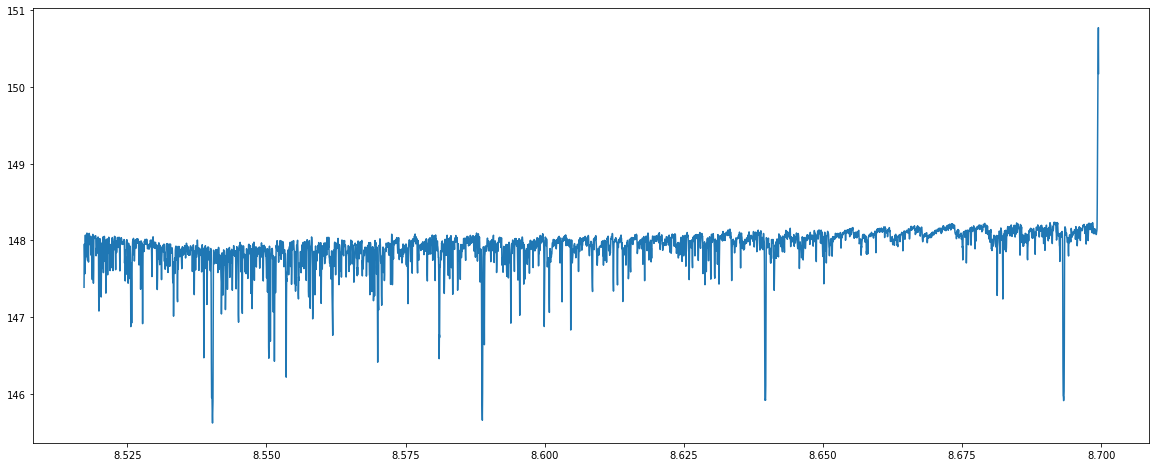

In [29]:
fig, ax = plt.subplots(figsize=(20,8))
data.plot_flux(ax,0,['data','flux'],['data','wave'])